In [1]:
import os
import json

import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from comparison.wasserstein import emd

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

font_path = '/home/andyclee/.fonts/LinLibertine_R.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

mpl.rcParams['font.family'] = 'Linux Libertine'

In [3]:
def calc_dists(arr, attr_dict, kappa):

    opairs = []

    max_edges = (kappa - 1) * (kappa - 2) / 2
    three_walks = (arr @ arr) @ arr
    for v, vtype in attr_dict.items():
        deg = sum(arr[v])

        assort = 0
        for u, con in enumerate(arr[v]):
            if con and attr_dict[u] == attr_dict[v]:
                assort += 1
            elif con and attr_dict[u] != attr_dict[v]:
                assort -= 1

        if deg == 0:
            assort = 0
        else:
            assort = assort / deg

        ccoeff = 0
        if deg <= 1:
            ccoeff = 0
        else:
            ccoeff = (three_walks[v][v] / 2) / (deg * (deg - 1))

        opairs.append( ( (assort + 1) / 2, ccoeff) )

    dist_map = {}
    for op in opairs:
        if op in dist_map:
            dist_map[op] += 1
        else:
            dist_map[op] = 1

    dist = []
    for op, freq in dist_map.items():
        dist.append( (op, freq / len(attr_dict)) )

    return dist

def avg_dists(dists):
    dist_freq = {}
    for d in dists:
        for op, freq in d:
            if op in dist_freq:
                dist_freq[op] += freq
            else:
                dist_freq[op] = freq
    for op, freq in dist_freq.items():
        dist_freq[op] = freq / len(dists)

    return [ (op, freq) for op, freq in dist_freq.items() ]

In [4]:
# try a new metric that has global and local
def triangle_count(adj_mat):
    return np.trace(np.linalg.matrix_power(adj_mat, 3)) / 6

def assortativity_coeff(adj_mat, types):
    n = len(adj_mat)
    
    # 2 times the edge count, based on paper normalization
    m = np.sum(adj_mat)
    e = np.zeros((2, 2))
    for i in range(n):
        for j in range(n):
            if adj_mat[i][j] != 1:
                continue
            
            if types[i] == types[j] and types[i] == -1:
                e[0][0] += 1
            elif types[i] != types[j] and types[i] == -1:
                e[0][1] += 1
            elif types[i] != types[j] and types[i] == 1:
                e[1][0] += 1
            elif types[i] == types[j] and types[i] == 1:
                e[1][1] += 1
    
    e = e / m
    e_square = np.square(e)
    es_sum = np.sum(e_square)
    e_trace = np.trace(e)
    assort = (e_trace - es_sum) / (1 - es_sum)
    return (assort + 1) / 2

def ntwk_metric(dist1, tc1, assort1, dist2, tc2, assort2):
    distr_metric = emd(dist1, dist2)
    
    tc_diff = abs(tc1 - tc2) / (tc1 + tc2) # https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    assort_diff = abs(assort1 - assort2) / (assort1 + assort2)
    global_diff = (tc_diff + assort_diff) # don't divide by 2 because distributional metric is between [0, 2]
    
    return (distr_metric + global_diff) / 2

In [5]:
def read_ntwks(data_dir, cn=None, ck=None):
    ntwks = {}
    for fn in os.listdir(data_dir):
        if fn == 'blank.txt' or fn == '.DS_Store':
            continue
            
        n, k, sc, ho, ftype_ext = fn.split('_')
        ftype, ext = ftype_ext.split('.')
        
        if cn is not None and int(n) != cn:
            continue
        if ck is not None and int(k) != ck:
            continue

        if sc not in ntwks:
            ntwks[sc] = {}
        if ho not in ntwks[sc]:
            ntwks[sc][ho] = {}

        if ftype == 'networks':

            # Get ablation stats
            ndata = {}
            with open(os.path.join(data_dir, fn), 'r') as sf:
                ndata = json.loads(sf.read())
                nobudget_runs = len(ndata['nobudget'])
                nolocal_runs = len(ndata['nolocal'])
                nostruct_runs = len(ndata['nostruct'])
                noattr_runs = len(ndata['noattr'])
                
                if nobudget_runs < 10:
                    print('nobudget runs', nobudget_runs, sc, ho)
                if nolocal_runs < 10:
                    print('nolocal runs', nolocal_runs, sc, ho)
                if nostruct_runs < 10:
                    print('nostruct runs', nostruct_runs, sc, ho)
                if noattr_runs < 10:
                    print('noattr runs', noattr_runs, sc, ho)

            ntwks[sc][ho]['networks'] = ndata
        elif ftype == 'types':
            tdata = {}
            with open(os.path.join(data_dir, fn), 'r') as tf:
                tdata = json.loads(tf.read())
                
            ntwks[sc][ho]['types'] = { int(i) : int(tdict['init_attrs']) for i, tdict in tdata.items() }
    return ntwks, int(k)

In [6]:
def plot_network(adj_mat, types):
    nx_g = nx.from_numpy_matrix(np.array(adj_mat))
    type_colors = []
    for i in range(len(adj_mat)):
        if types[i] == -1:
            type_colors.append('r')
        else:
            type_colors.append('b')
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(nx_g, node_color=type_colors, pos=nx.spring_layout(nx_g), with_labels=False, node_size=100)
    plt.show()

In [7]:
# our observed network, vill_no specifies the village to select
vill_no = 10

stata_household = pd.read_stata('./banerjee_data/datav4.0/Data/2. Demographics and Outcomes/household_characteristics.dta')
file = './banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + 'allVillageRelationships' +'_HH_vilno_' + str(vill_no) + '.csv'

# adjacency matrix for village
vill_mat = (pd.read_csv(file, header=None)).to_numpy()
stata_vill = stata_household.where(stata_household['village'] == vill_no).dropna(how = 'all')
room_type = np.array(stata_vill['room_no']/np.sqrt((stata_vill['bed_no']+1))<=2)

# type dict
room_type_dict = {k: int(v)*2 -1 for k, v in enumerate(room_type)}

Best fit ablation nobudget sc 1.0 ho 0.5 emd 0.1262793133195268


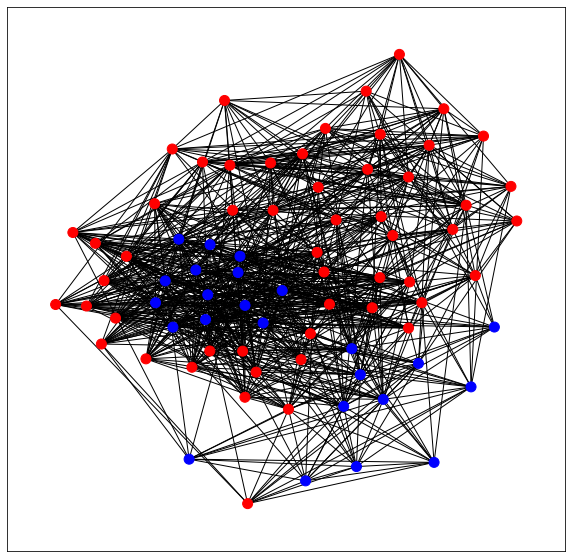

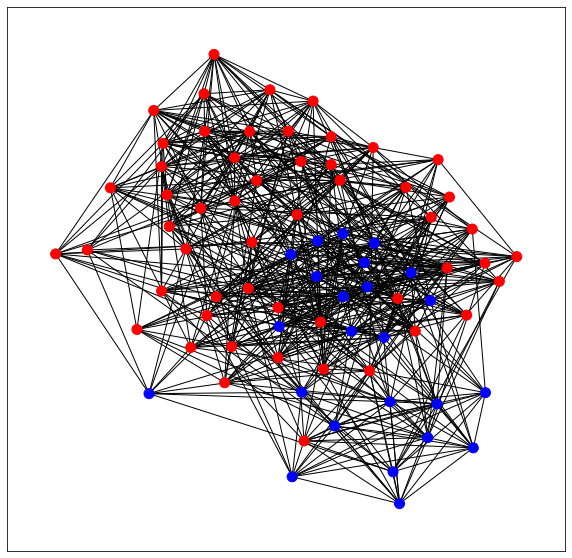

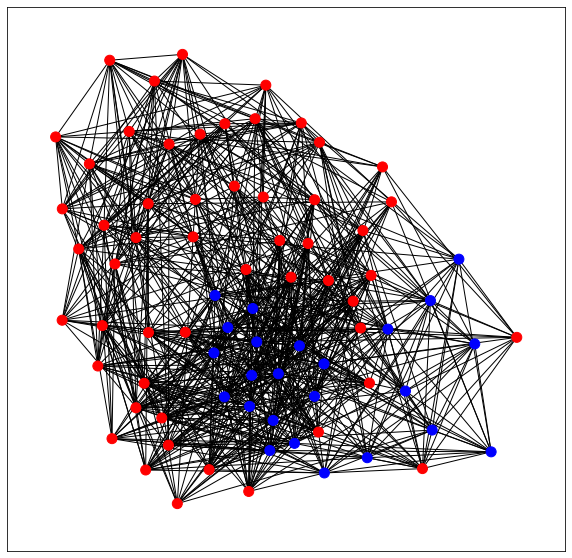

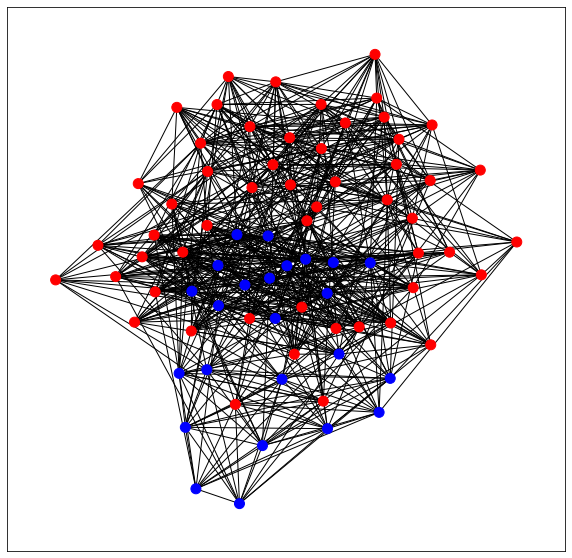

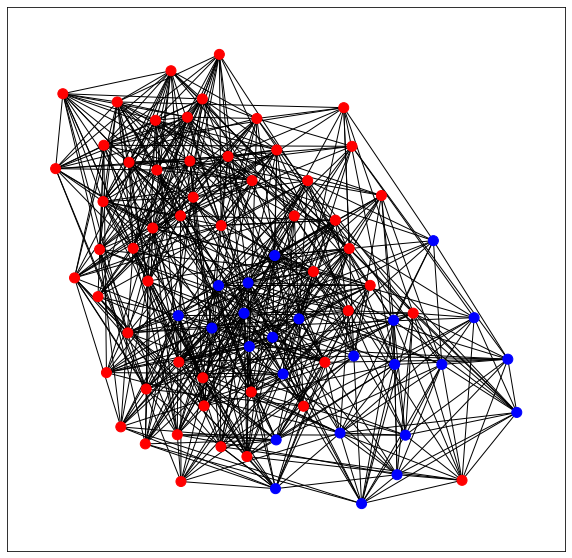

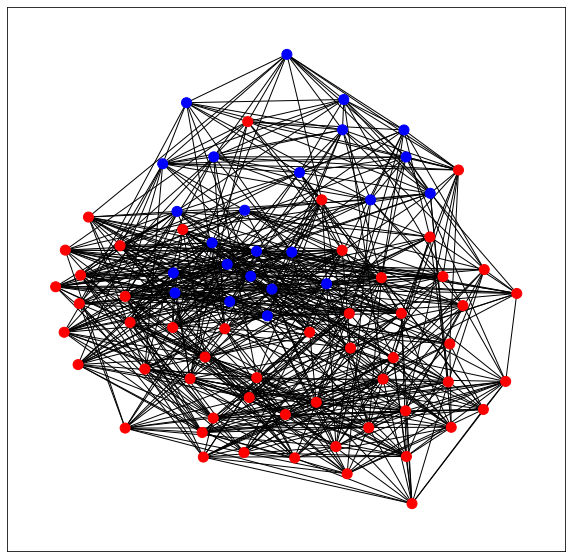

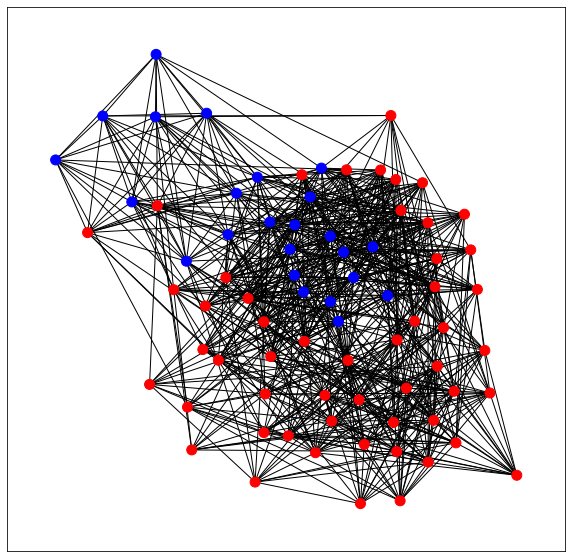

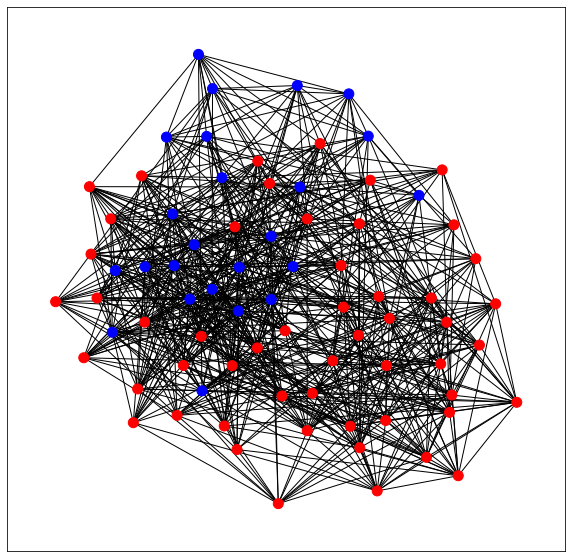

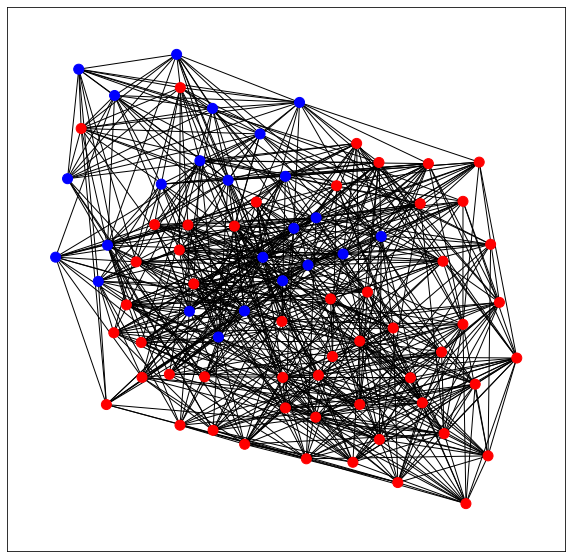

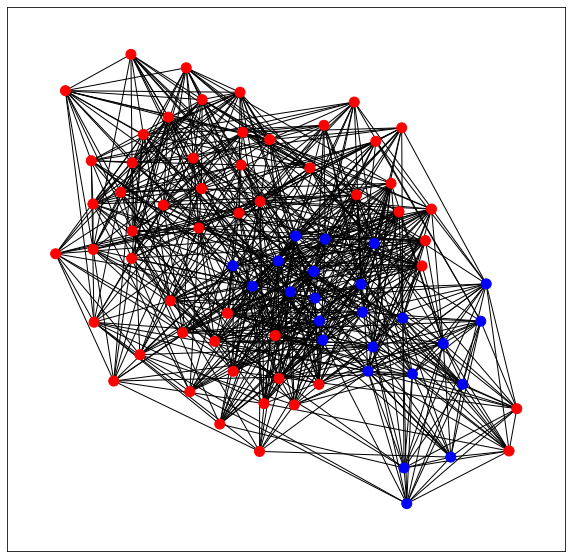

Best fit ablation nolocal sc 0.125 ho 1.0 emd 0.28119573198321035


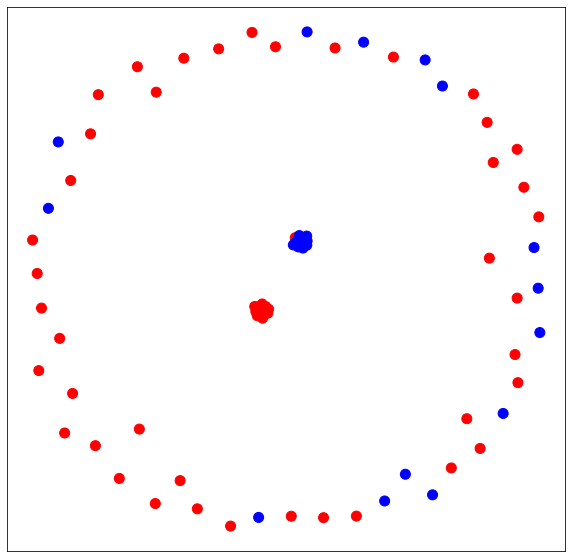

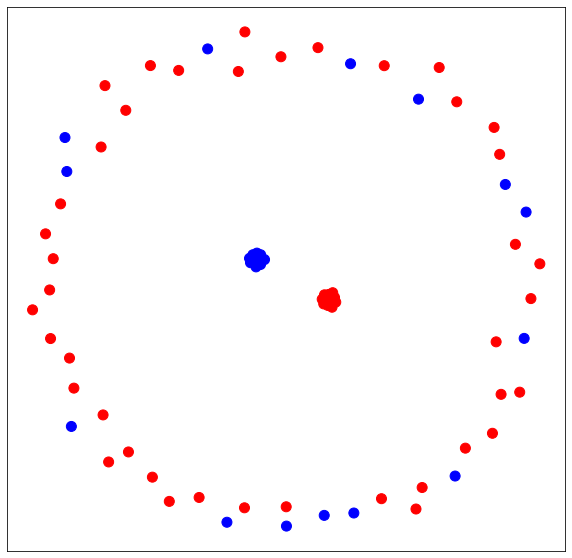

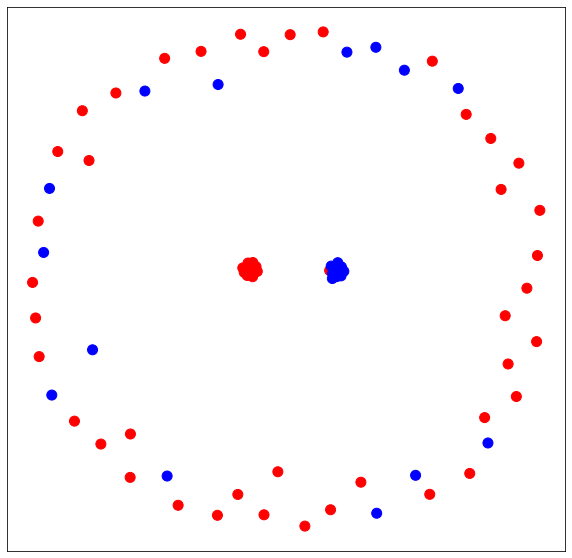

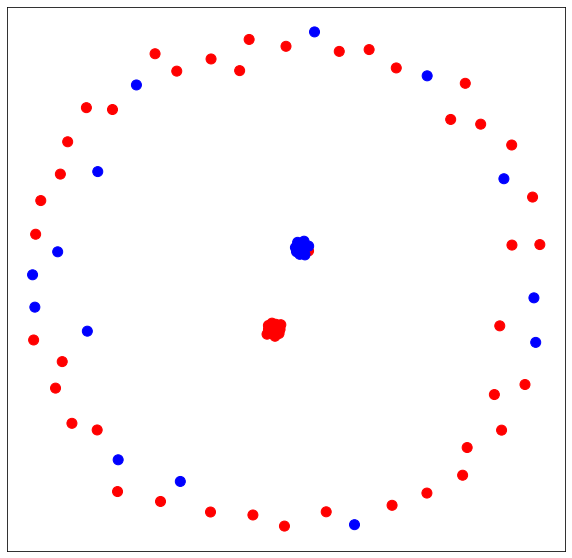

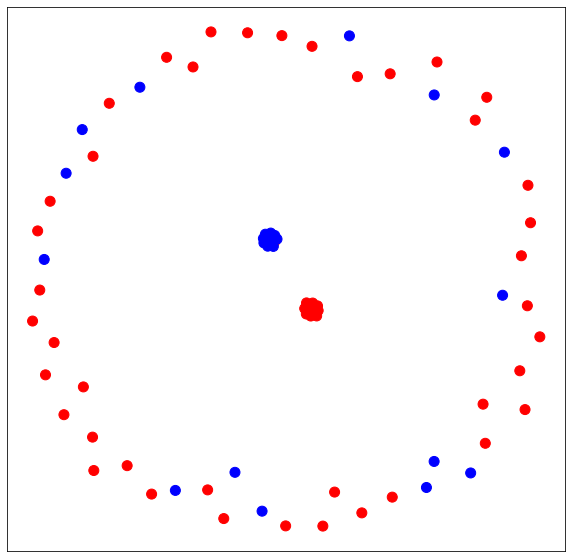

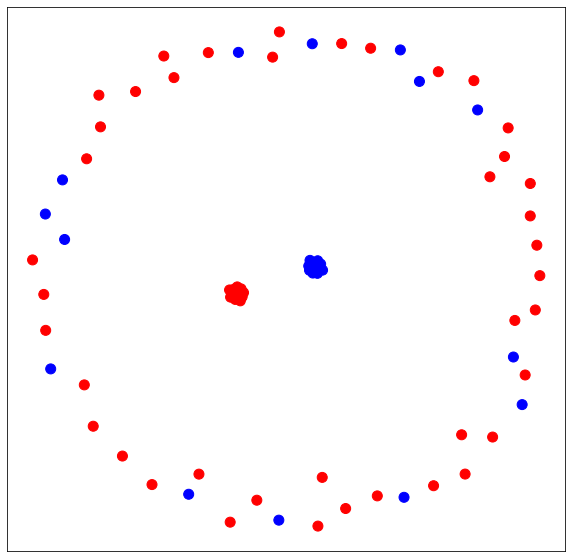

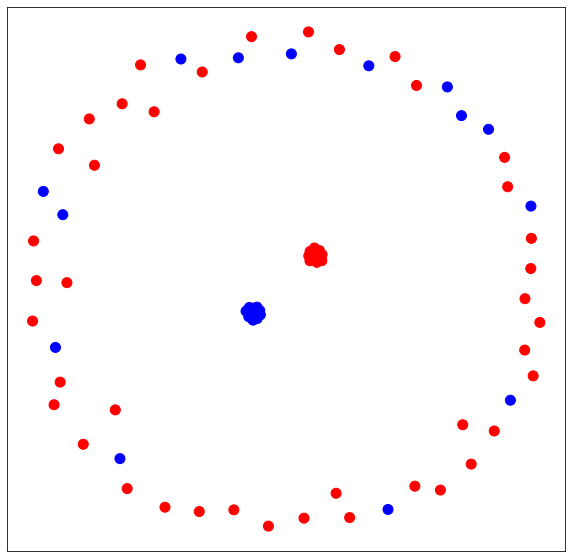

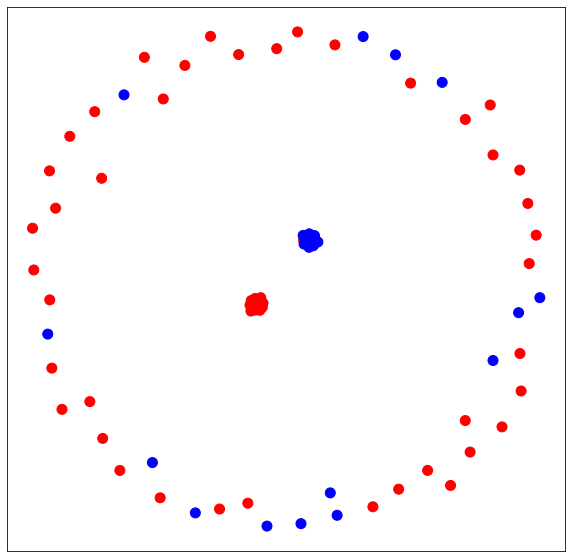

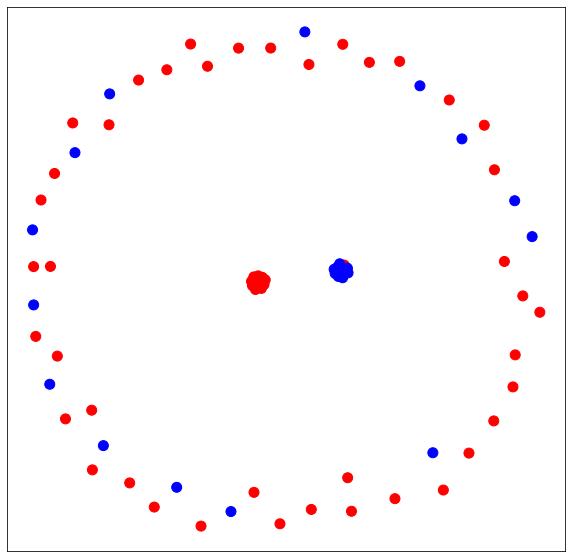

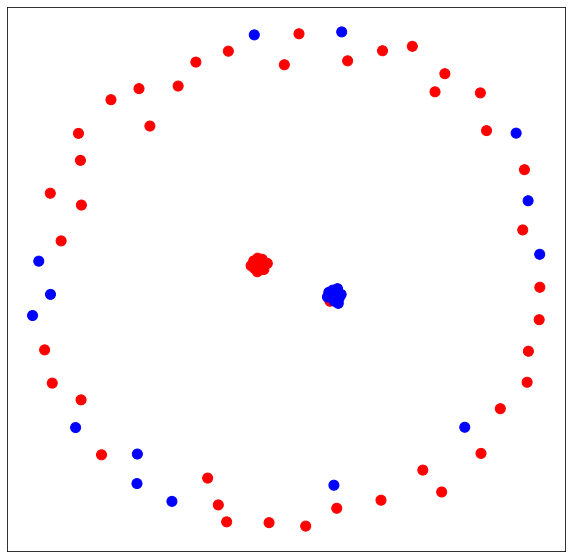

Best fit ablation nostruct sc 0.5 ho 0.5 emd 0.21876281568281128


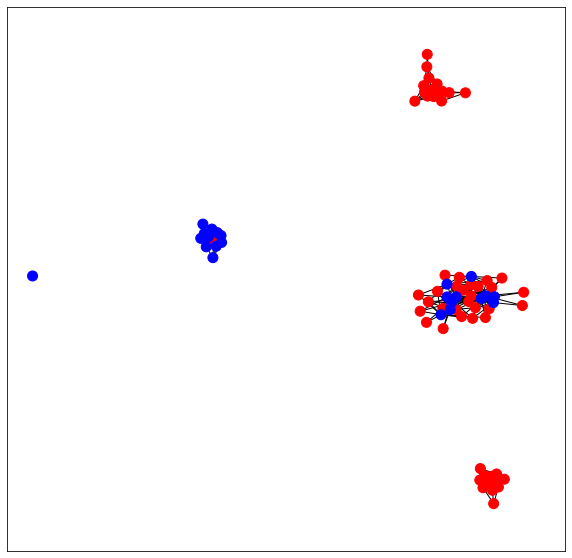

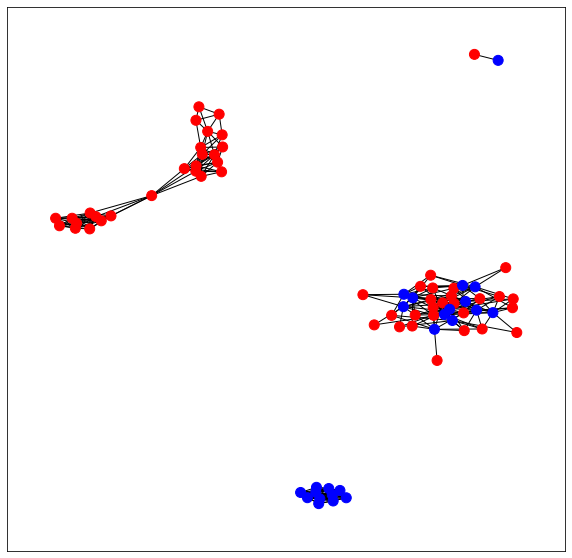

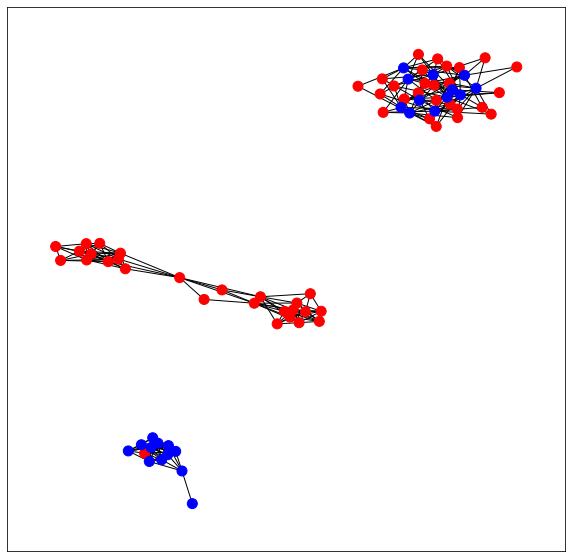

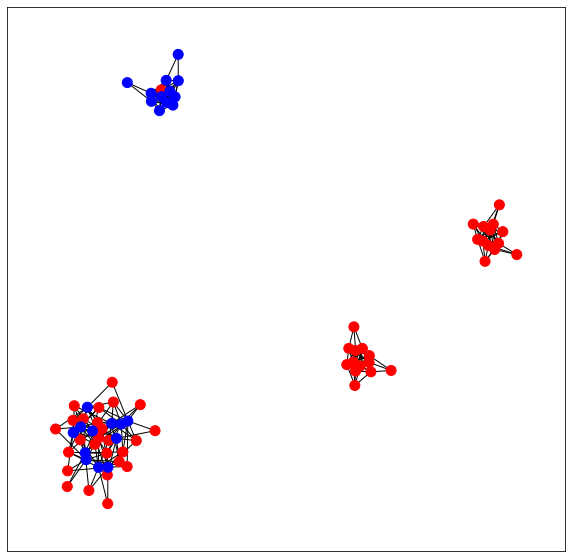

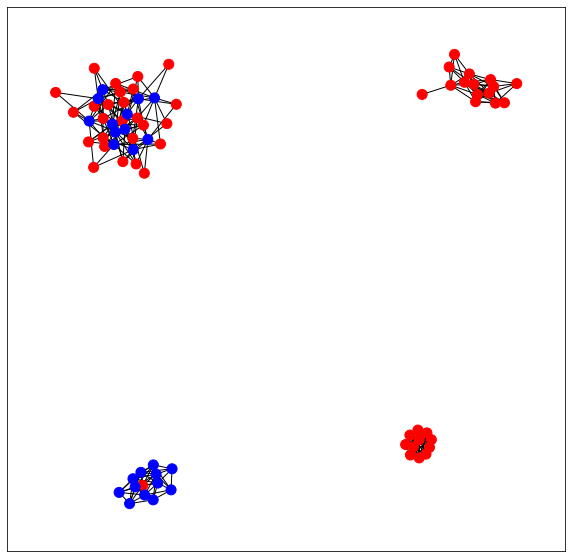

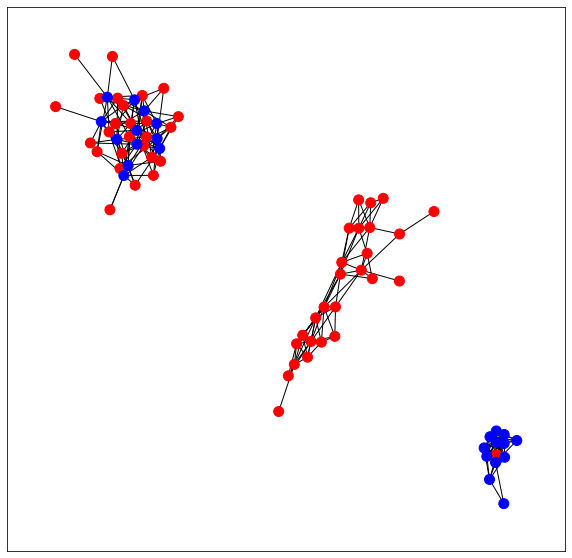

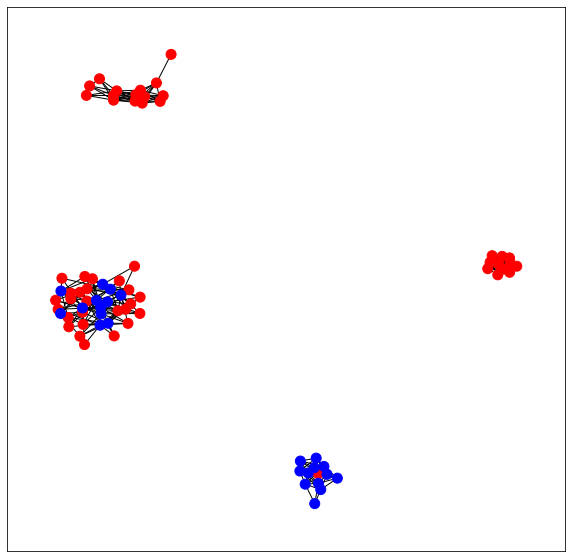

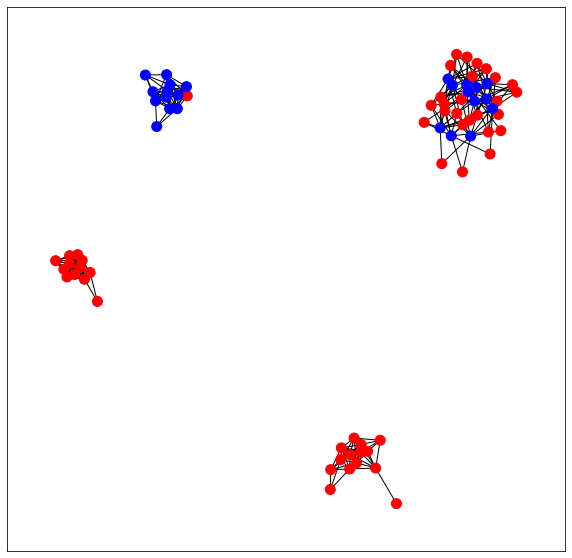

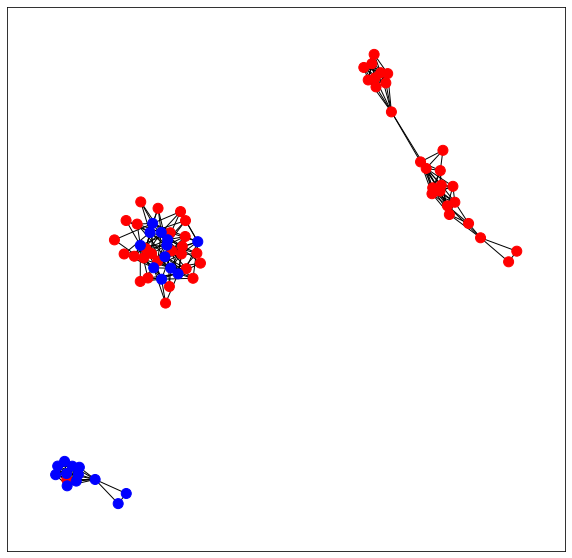

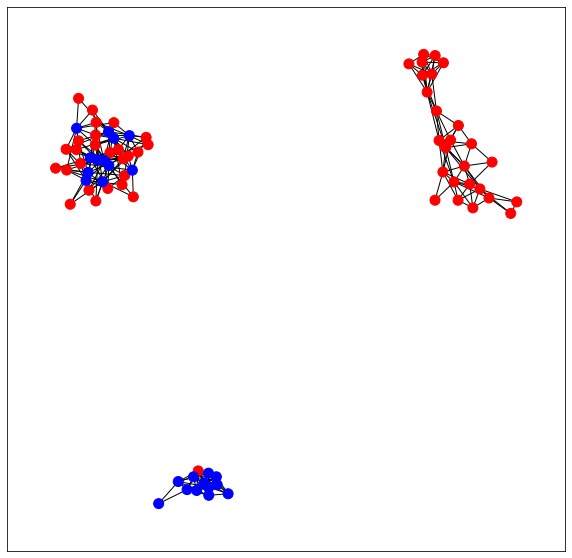

In [ ]:
abl_data = 'abl_vill10/'
abl_ntwks_dict, k = read_ntwks(abl_data)

vill_dist = calc_dists(vill_mat, room_type_dict, k)
vill_weights = [ vd[1] for vd in vill_dist ]

ablations = ['nobudget', 'nolocal', 'nostruct', 'noattr']
abl_names = ['No Budget', 'No Locality', 'No structure', 'No attribute']

for abl in ablations:
    best_emd = np.infty
    best_sc = None
    best_ho = None
    best_ntwks = []
    for sc in abl_ntwks_dict.keys():
        for ho in abl_ntwks_dict[sc].keys():
            abl_ntwks = abl_ntwks_dict[sc][ho]['networks'][abl]
            abl_types = abl_ntwks_dict[sc][ho]['types']
            
            kappa = -1
            if abl == 'nobudget':
                kappa = len(abl_types)
            else:
                kappa = k
            abl_dists = [ calc_dists(np.array(abl_n), abl_types, kappa) for abl_n in abl_ntwks ]
            avg_abl_dist = avg_dists(abl_dists)
            
            #vill_emd = emd(avg_abl_dist, vill_dist)
            abl_tri_count = np.mean([ triangle_count(np.array(abl_n)) for abl_n in abl_ntwks ])
            abl_assort = np.mean([ assortativity_coeff(np.array(abl_n), abl_types) for abl_n in abl_ntwks ])
            
            vill_tri_count = triangle_count(vill_mat)
            vill_assort = assortativity_coeff(vill_mat, room_type_dict)
            
            vill_emd = ntwk_metric(avg_abl_dist, abl_tri_count, abl_assort, vill_dist, vill_tri_count, vill_assort)
            if vill_emd < best_emd:
                best_emd = vill_emd
                best_sc = sc
                best_ho = ho
                best_ntwks = abl_ntwks
                
    print('Best fit ablation', abl, 'sc', best_sc, 'ho', best_ho, 'emd', best_emd)
    
    for ntwk in best_ntwks:
        plot_network(ntwk, abl_ntwks_dict[sc][ho]['types'])